In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from gensim import corpora
from sklearn.metrics import classification_report

NLTK for tokenizing and stemming text.

In [2]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 57.2 MB/s eta 0:00:00


In [6]:
# TODO: Download and Load the "yelp_reviews_subset_2.csv" dataset uploaded on the notion page using pandas
df = pd.read_csv('/content/yelp_reviews_subset_2.csv')  # Replace None with the correct code
df

,Unnamed: 0,Text,Labels
0,0,My expectations for McDonalds are t rarely hig...,0
1,1,I've tried to give this McDonalds a chance but...,0
2,2,This McDonald's is so bad it's amazing. \n\nO...,0
3,3,We had the worst possible experience at the Ea...,0
4,4,They burned my fish and they burned it bad. O...,2
...,...,...,...
495,495,This place is PHENOMENAL.\nI got my bunny here...,4
496,496,"This is a bizarre CVS, the kind you would only...",1
497,497,"I go to this CVS all the time, since I work in...",1
498,498,"Never again. Let me repeat, never again. \n\nT...",0


/tmp/ipython-input-586133965.py:14: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df['sentiment']).plot.bar(title="Sentiment distribution in df")


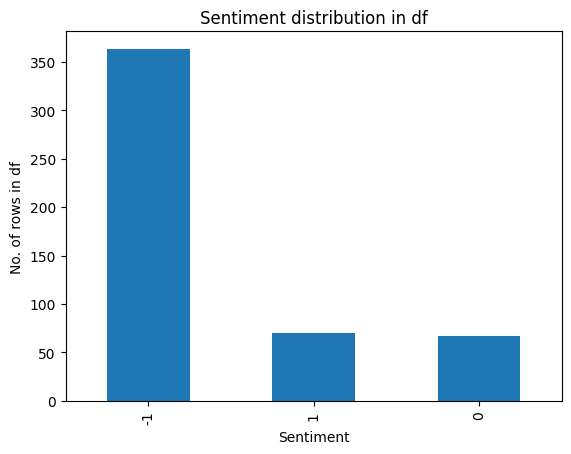

In [7]:
def map_sentiment(stars_received):
    if stars_received <= 2:
        return -1
    elif stars_received == 3:
        return 0
    else:
        return 1


# Mapping stars to sentiment into three categories
df['sentiment'] = [ map_sentiment(x) for x in df['Labels']]
# Plotting the sentiment distribution
plt.figure()
pd.value_counts(df['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [18]:
# TODO: Tokenize each sentence into word tokens and store them as a list in the dataframe
# Use List Comprehension

# Assuming df['text'] contains the original review sentences
df['tokenized_text'] = [word_tokenize(text) for text in df['Text']]
print(df['tokenized_text'].head(10))

ps = PorterStemmer()
# TODO: Use the Porter Stemmer to find stem words of each word for all the words in df["tokenized_text"]
# Hint: Use List Comprehension
df['stemmed_tokens'] = [[ps.stem(word) for word in tokens] for tokens in df['tokenized_text']] # Replace None with the correct code
df['stemmed_tokens'].head(10)

0    [My, expectations, for, McDonalds, are, t, rar...
1    [I, 've, tried, to, give, this, McDonalds, a, ...
2    [This, McDonald, 's, is, so, bad, it, 's, amaz...
3    [We, had, the, worst, possible, experience, at...
4    [They, burned, my, fish, and, they, burned, it...
5    [Some, how, even, though, the, food, at, this,...
6    [Mmm, ..., peppermint, mocha\n\nIn, my, quest,...
7    [If, there, was, ever, a, \, '', get, your, co...
8    [I, just, realized, they, remodeled, this, one...
9    [Great, location, !, Close, to, shops, and, th...
Name: tokenized_text, dtype: object


,stemmed_tokens
0,"[my, expect, for, mcdonald, are, t, rare, high..."
1,"[i, 've, tri, to, give, thi, mcdonald, a, chan..."
2,"[thi, mcdonald, 's, is, so, bad, it, 's, amaz,..."
3,"[we, had, the, worst, possibl, experi, at, the..."
4,"[they, burn, my, fish, and, they, burn, it, ba..."
5,"[some, how, even, though, the, food, at, thi, ..."
6,"[mmm, ..., peppermint, mocha\n\nin, my, quest,..."
7,"[if, there, wa, ever, a, \, '', get, your, cof..."
8,"[i, just, realiz, they, remodel, thi, one, rec..."
9,"[great, locat, !, close, to, shop, and, theatr..."


In [19]:
# Train Test Split Function
def split_train_test(df, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(df[["Text", "Labels", "tokenized_text", "stemmed_tokens"]],
                                                        df['sentiment'],
                                                        shuffle=shuffle_state,
                                                        test_size=test_size,
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(df)

Value counts for Train sentiments
sentiment
-1    255
 1     49
 0     46
Name: count, dtype: int64
Value counts for Test sentiments
sentiment
-1    108
 1     21
 0     21
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index                                               Text  Labels  \
0    139  The food is standard American fare--a bit over...       1   
1    129  I'm not much of a beer drinker, but my fiancee...       3   
2    258  ok so i've eaten here more than once but just ...       1   
3    227  Food was ok had a steak w/ shrimp side Ass mas...       1   
4     60  He was incredibly sexist/homophobic. He could ...       0   

                                      tokenized_text  \
0  [The, food, is, standard, American, fare, --, ...   
1  [I, 'm, not, much, of, a, beer, drinker, ,, bu...   
2  [ok, so, i, 've, eaten, here, more, than, once...   
3  [Food, was, ok, had, a, steak, w/, shrimp, sid...   
4  [He, was, incredi

In [21]:

# TODO: Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Corrected code
print("Device available for running: ")
print(device)

Device available for running: 
cpu


In [46]:
import torch.nn as nn
import torch.nn.functional as F

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(FeedforwardNeuralNetModel, self).__init__()

        # TODO: Add an fc1 layer as described below
        # Linear function 1: vocab_size --> hidden_dim
        # The input_dim is usually the vocab_size for text classification
        self.fc1 = nn.Linear(input_dim, hidden_dim)

        # Non-linearity 1
        self.relu1 = nn.ReLU()

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # TODO: Add an fc2 layer as described below
        # Linear function 2: hidden_dim --> hidden_dim
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

        # Non-linearity 2
        self.relu2 = nn.ReLU()

        # TODO: Add an fc3 layer as described below
        # Linear function 3 (readout): hidden_dim --> output_dim
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        # TODO: Forward pass through fully connected layer 1
        out = self.fc1(x)

        # Non-linearity 1
        out = self.relu1(out)

        # Apply dropout
        out = self.dropout(out)

        # TODO: Forward pass through fully connected layer 2
        out = self.fc2(out)

        # Non-linearity 2
        out = self.relu2(out)

        # TODO: Forward pass through fully connected layer 3
        out = self.fc3(out)

        # The output layer uses Softmax to get class probabilities
        return out

In [23]:
# Function to return the dictionary either with padding word or without padding
def make_dict(top_data_df_small, padding=True):
    if padding:
        print("Dictionary with padded token added")
        review_dict = corpora.Dictionary([['pad']])
        review_dict.add_documents(top_data_df_small['stemmed_tokens'])
    else:
        print("Dictionary without padding")
        review_dict = corpora.Dictionary(top_data_df_small['stemmed_tokens'])
    return review_dict

# Make the dictionary without padding for the basic models
review_dict = make_dict(df, padding=False)

Dictionary without padding


In [24]:
VOCAB_SIZE = 30056
NUM_LABELS = 3

# Function to make bow vector to be used as input to network
def make_bow_vector(review_dict, sentence):
    vec = torch.zeros(VOCAB_SIZE, dtype=torch.float64, device=device)
    for word in sentence:
        vec[review_dict.token2id[word]] += 1
    return vec.view(1, -1).float()

# Function to get the output tensor
def make_target(label):
    if label == -1:
        return torch.tensor([0], dtype=torch.long, device=device)
    elif label == 0:
        return torch.tensor([1], dtype=torch.long, device=device)
    else:
        return torch.tensor([2], dtype=torch.long, device=device)

In [28]:
import torch.nn as nn
import torch.optim as optim

VOCAB_SIZE = len(review_dict)

input_dim = VOCAB_SIZE
hidden_dim = 500
output_dim = 3
num_epochs = 100

# TODO: Call the FeedForwardNeuralNetwork Class object with appropriate arguements
# The arguments correspond to the dimensions defined above.
ff_nn_bow_model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim) # Corrected code

# TODO: Move the model to device
# Moves the entire model (including all its parameters) to the specified device (GPU or CPU).
ff_nn_bow_model = ff_nn_bow_model.to(device) # Corrected code

# TODO: Define the loss function as Cross Entropy Loss
# CrossEntropyLoss is standard for multi-class classification problems.
loss_function = nn.CrossEntropyLoss() # Corrected code

# TODO: Define a Stochastic Gradient Descent Optimizer with learning rate of 1e-3
# We pass the model's parameters and the specified learning rate to the optimizer.
optimizer = optim.SGD(ff_nn_bow_model.parameters(), lr=1e-3) # Corrected code


In [42]:
# Open the file for writing loss
ffnn_loss_file_name = 'ffnn_bow_class_big_loss_500_epoch_100_less_lr.csv'
f = open(ffnn_loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []
iter = 0
# Start training
for epoch in range(num_epochs):
    if (epoch+1) % 25 == 0:
        print("Epoch completed: " + str(epoch+1))
    train_loss = 0
    for index, row in X_train.iterrows():
        # Clearing the accumulated gradients
        optimizer.zero_grad()

        # TODO: Make the bag of words vector for stemmed tokens
        # The bow vector is created, unsqueezed to add the batch dimension (batch size 1), and moved to the device.
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens']).to(device) # Replace None with the correct code

        # TODO: Forward pass to get output
        # Pass the bow vector through the model.
        probs = ff_nn_bow_model(bow_vec) # Replace None with the correct code

        # Get the target label
        # The target label is created and moved to the device.
        target = make_target(Y_train['sentiment'][index]).to(device)

        # TODO: Calculate Loss: softmax --> cross entropy loss
        # Calculates the loss between the model's output and the true target label.
        loss = loss_function(probs, target) # Replace None with the correct code

        # Accumulating the loss over time
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0

f.close()

Epoch completed: 25
Epoch completed: 50
Epoch completed: 75
Epoch completed: 100


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.72      1.00      0.84       108
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00        21

    accuracy                           0.72       150
   macro avg       0.24      0.33      0.28       150
weighted avg       0.52      0.72      0.60       150

100
Index(['iter', ' loss'], dtype='object')


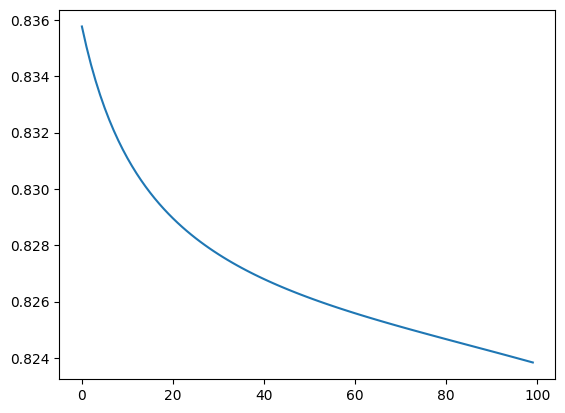

In [43]:
bow_ff_nn_predictions = []
original_lables_ff_bow = []

with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
        probs = ff_nn_bow_model(bow_vec)
        bow_ff_nn_predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_lables_ff_bow.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])

print(classification_report(original_lables_ff_bow,bow_ff_nn_predictions))
ffnn_loss_df = pd.read_csv(ffnn_loss_file_name)
print(len(ffnn_loss_df))
print(ffnn_loss_df.columns)
ffnn_plt_500_padding_100_epochs = ffnn_loss_df[' loss'].plot()
fig = ffnn_plt_500_padding_100_epochs.get_figure()
fig.savefig("ffnn_bow_loss_500_padding_100_epochs_less_lr.jpg")

In [48]:
# Assuming a dropout_rate is defined, consistent with the model's new feature
dropout_rate = 0.5
ff_nn_bow_model_dropout = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim, dropout_rate) # Replace None with model initialization (include dropout_rate parameter)
ff_nn_bow_model_dropout.to(device)

# TODO: Define loss function and optimizer
loss_function_dropout = nn.CrossEntropyLoss()  # Replace None with appropriate loss function
optimizer_dropout = optim.SGD(ff_nn_bow_model_dropout.parameters(), lr=1e-3)  # Replace None with optimizer

# TODO: Prepare to record training loss
ffnn_loss_file_name_dropout = 'ffnn_bow_class_big_loss_500_epoch_100_less_lr_dropout.csv'
f_dropout = open(ffnn_loss_file_name_dropout, 'w')
f_dropout.write('iter, loss\n')
losses_dropout = []
iter_dropout = 0

# Train the model
ff_nn_bow_model_dropout.train()
for epoch in range(num_epochs):
    if (epoch + 1) % 2 == 0:
        print(f"Epoch completed: {epoch + 1}")

    train_loss_dropout = 0

    # TODO: Iterate through training samples
    for index, row in X_train.iterrows():
        optimizer_dropout.zero_grad()

        # TODO: Create bag-of-words input vector and target
        # Create BoW vector, add batch dimension (.unsqueeze(0)), and move to device.
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens']).to(device)  # Replace None with code to create BoW vector

        # Forward pass through the dropout model.
        probs = ff_nn_bow_model_dropout(bow_vec)  # Replace None with forward pass through the model

        # Create target tensor and move to device.
        target = make_target(Y_train['sentiment'][index]).to(device)  # Replace None with code to create target tensor

        # TODO: Compute loss
        loss = loss_function_dropout(probs, target)  # Replace None with loss computation
        train_loss_dropout += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer_dropout.step()

    # Log average loss for the epoch
    f_dropout.write(f"{epoch + 1},{train_loss_dropout / len(X_train)}\n")
    train_loss_dropout = 0

f_dropout.close()

Epoch completed: 2
Epoch completed: 4
Epoch completed: 6
Epoch completed: 8
Epoch completed: 10
Epoch completed: 12
Epoch completed: 14
Epoch completed: 16
Epoch completed: 18
Epoch completed: 20
Epoch completed: 22
Epoch completed: 24
Epoch completed: 26
Epoch completed: 28
Epoch completed: 30
Epoch completed: 32
Epoch completed: 34
Epoch completed: 36
Epoch completed: 38
Epoch completed: 40
Epoch completed: 42
Epoch completed: 44
Epoch completed: 46
Epoch completed: 48
Epoch completed: 50
Epoch completed: 52
Epoch completed: 54
Epoch completed: 56
Epoch completed: 58
Epoch completed: 60
Epoch completed: 62
Epoch completed: 64
Epoch completed: 66
Epoch completed: 68
Epoch completed: 70
Epoch completed: 72
Epoch completed: 74
Epoch completed: 76
Epoch completed: 78
Epoch completed: 80
Epoch completed: 82
Epoch completed: 84
Epoch completed: 86
Epoch completed: 88
Epoch completed: 90
Epoch completed: 92
Epoch completed: 94
Epoch completed: 96
Epoch completed: 98
Epoch completed: 100


Classification Report with Dropout:
              precision    recall  f1-score   support

           0       0.79      0.91      0.84       108
           1       0.30      0.14      0.19        21
           2       0.44      0.33      0.38        21

    accuracy                           0.72       150
   macro avg       0.51      0.46      0.47       150
weighted avg       0.67      0.72      0.69       150



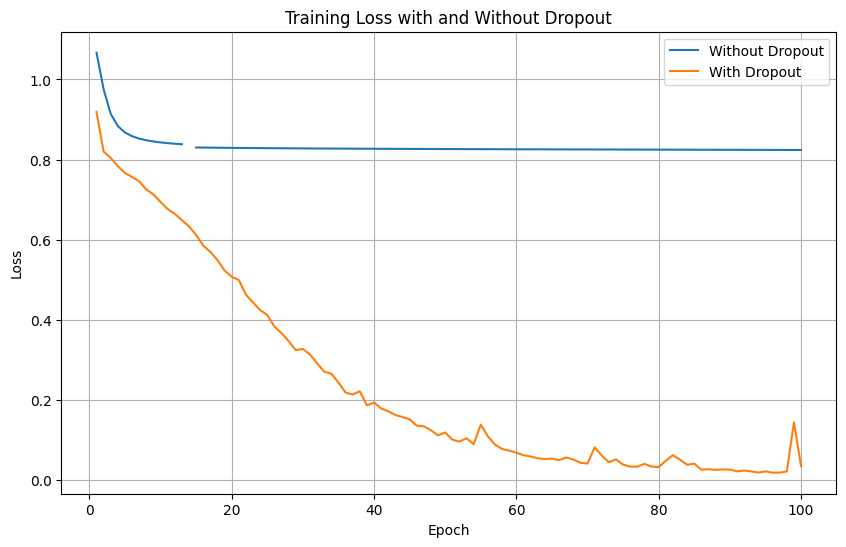

In [49]:
bow_ff_nn_predictions_dropout = []
original_lables_ff_bow_dropout = []

ff_nn_bow_model_dropout.eval() # Set model to evaluation mode
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
        probs = ff_nn_bow_model_dropout(bow_vec)
        bow_ff_nn_predictions_dropout.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_lables_ff_bow_dropout.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])

print("Classification Report with Dropout:")
print(classification_report(original_lables_ff_bow_dropout, bow_ff_nn_predictions_dropout))

ffnn_loss_df = pd.read_csv(ffnn_loss_file_name)
ffnn_loss_df_dropout = pd.read_csv(ffnn_loss_file_name_dropout)

plt.figure(figsize=(10, 6))
plt.plot(ffnn_loss_df['iter'], ffnn_loss_df[' loss'], label='Without Dropout')
plt.plot(ffnn_loss_df_dropout['iter'], ffnn_loss_df_dropout[' loss'], label='With Dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss with and Without Dropout')
plt.legend()
plt.grid(True)
plt.savefig("ffnn_bow_loss_comparison_dropout.jpg")
plt.show()